# Demonstration of system capacity change detection

_Bennet Meyers, 9/17/20_

This notebook is a demonstration of the capacity change detection algorithms from Solar Data Tools. System capacity change detection is part of the standard data processing pipeline. The software will alert you if a capacity change is detected in a data set and find the change point(s).

In [1]:
from solardatatools.dataio import load_cassandra_data
from solardatatools import DataHandler

First, we load in an arbitrary power time-series data set. This data set is comprised of five-minute averages of AC power on a small fixed-tilt system with capacity less than 10kW.

In [2]:
df = load_cassandra_data('TAAI01129193')

Query of 261557 rows complete in 4.39 seconds


We have a dataframe of values

In [3]:
df.head()

,site,meas_name,ts,sensor,meas_val_f
0,TAAI01129193,ac_power,2014-01-01 00:00:00,839016424_SPR-8000f,0.77230
1,TAAI01129193,ac_power,2014-01-01 00:05:00,839016424_SPR-8000f,0.40505
2,TAAI01129193,ac_power,2014-01-01 00:10:00,839016424_SPR-8000f,0.30915
3,TAAI01129193,ac_power,2014-01-01 00:15:00,839016424_SPR-8000f,0.28485
4,TAAI01129193,ac_power,2014-01-01 00:20:00,839016424_SPR-8000f,0.25345


This data frame is passed to the `DataHandler` class constructor

In [4]:
dh = DataHandler(df, convert_to_ts=True)

Then we run the pipeline on the desired power column

In [5]:
dh.run_pipeline(power_col=dh.keys[0][-1])

total time: 3.46 seconds
--------------------------------
Breakdown
--------------------------------
Proprocessing              0.10s
Cleaning                   1.08s
Filtering/Summarizing      2.28s
    Data quality           0.38s
    Clear day detect       0.29s
    Clipping detect        0.24s
    Capacity change detect 1.37s



The whole pipeline excutes in under 5 seconds on a 2016 MacBook Pro. The capacity change analysis is one of the algorithms that gets executed in the "Filtering/Summarizing" block, and is typically one of the largest contributers to execution time.

Runing the `.report()` method prints a high-level summary of the data set. When a capacity change is detected, the user gets a warning, as shown below.

In [6]:
dh.report()

Length:                5.47 years
Capacity estimate:     6.64 kW
Data sampling:         5 minute
Data quality score:    82.6%
Data clearness score:  44.3%
Inverter clipping:     True
Time shifts corrected: False
Time zone correction:  None


Additionaly, the `.capacity_changes` attribute is set to `True`.

In [7]:
dh.capacity_changes

True

The algorithm is based off a signal demixing framework, which acts as an adaptive, robust change point detector. This can be visualized by running the following plotting function.

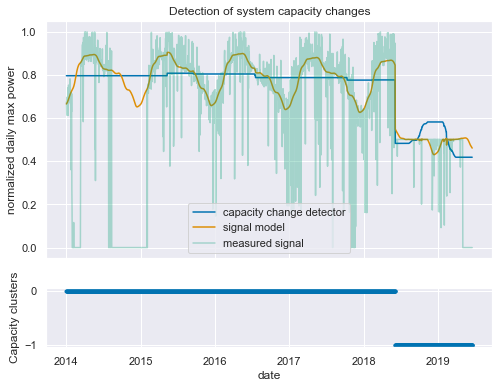

In [8]:
dh.plot_capacity_change_analysis();

By inspecting the heatmap representation of the power data, we can visually confirm the detected shift in capacity

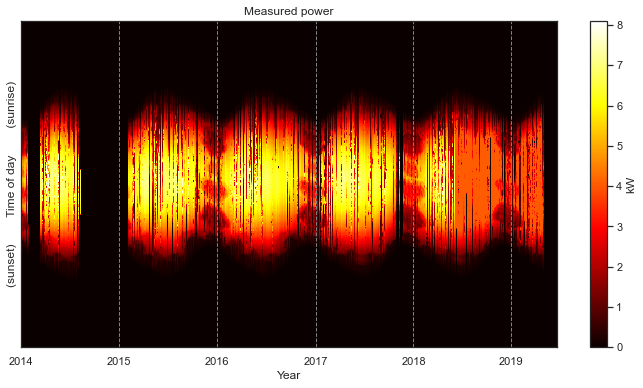

In [9]:
dh.plot_heatmap(matrix='filled');

We have access the the daily labels as well. This allows us to select only days at a certain capacity level for further analysis.

In [10]:
dh.capacity_analysis.labels

array([ 0,  0,  0, ..., -1, -1, -1])

Additionally, we can use this information to find the date of the shift, as shown here.

In [11]:
change_point = np.r_[[False], dh.capacity_analysis.labels[1:] != dh.capacity_analysis.labels[:-1]]
dh.day_index[change_point]

DatetimeIndex(['2018-06-06'], dtype='datetime64[ns]', freq='D')